# Bitcoin Prediction

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [92]:
df = pd.read_csv('bitcoin.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [93]:
df.shape

(2713, 7)

In [94]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


### EDA

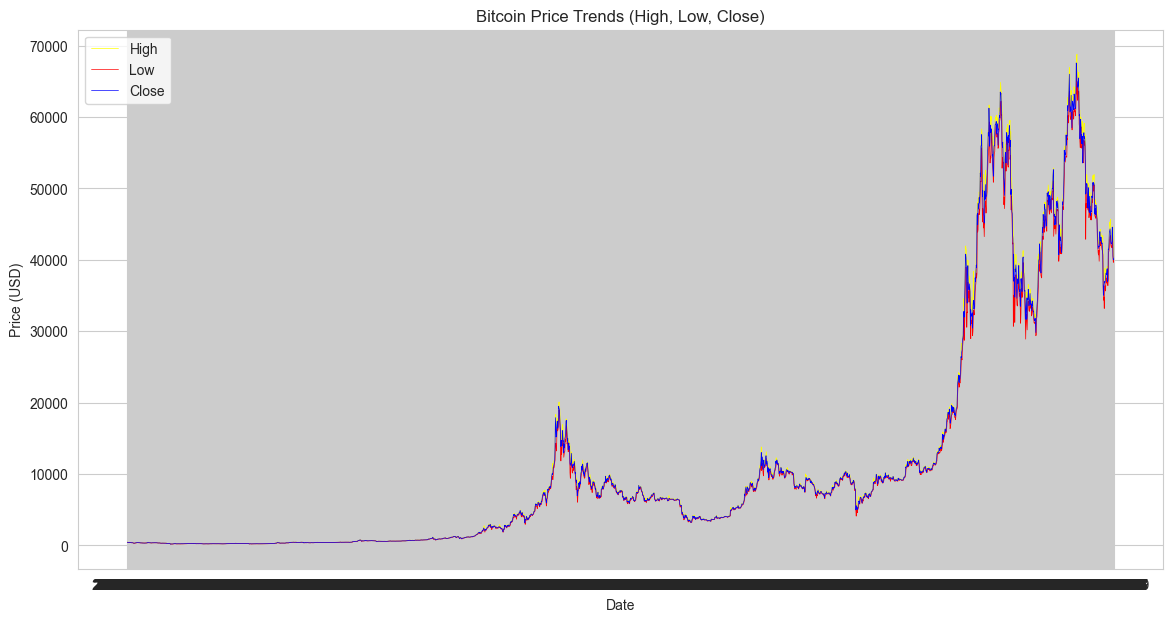

In [96]:
plt.figure(figsize=(14, 7))

plt.plot(df['Date'], df['High'], label='High', color='yellow', linewidth=0.5)
plt.plot(df['Date'], df['Low'], label='Low', color='red', linewidth=0.5)
plt.plot(df['Date'], df['Close'], label='Close', color='blue', linewidth=0.5)

plt.title('Bitcoin Price Trends (High, Low, Close)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.show()

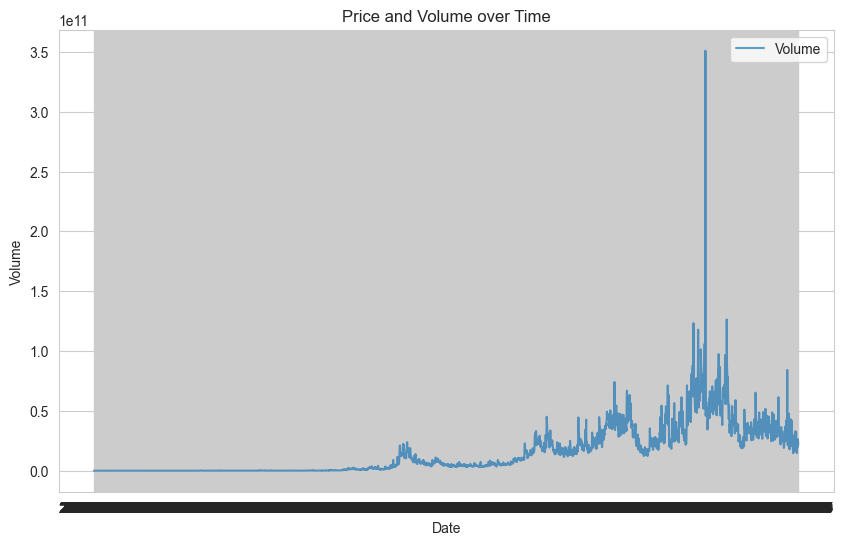

In [97]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Volume'], label='Volume', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Price and Volume over Time")
plt.legend()
plt.show()

In [98]:
df[df['Close'] == df['Adj Close']].shape
df.shape

(2713, 7)

In [99]:
df = df.drop('Adj Close', axis=1)

In [100]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

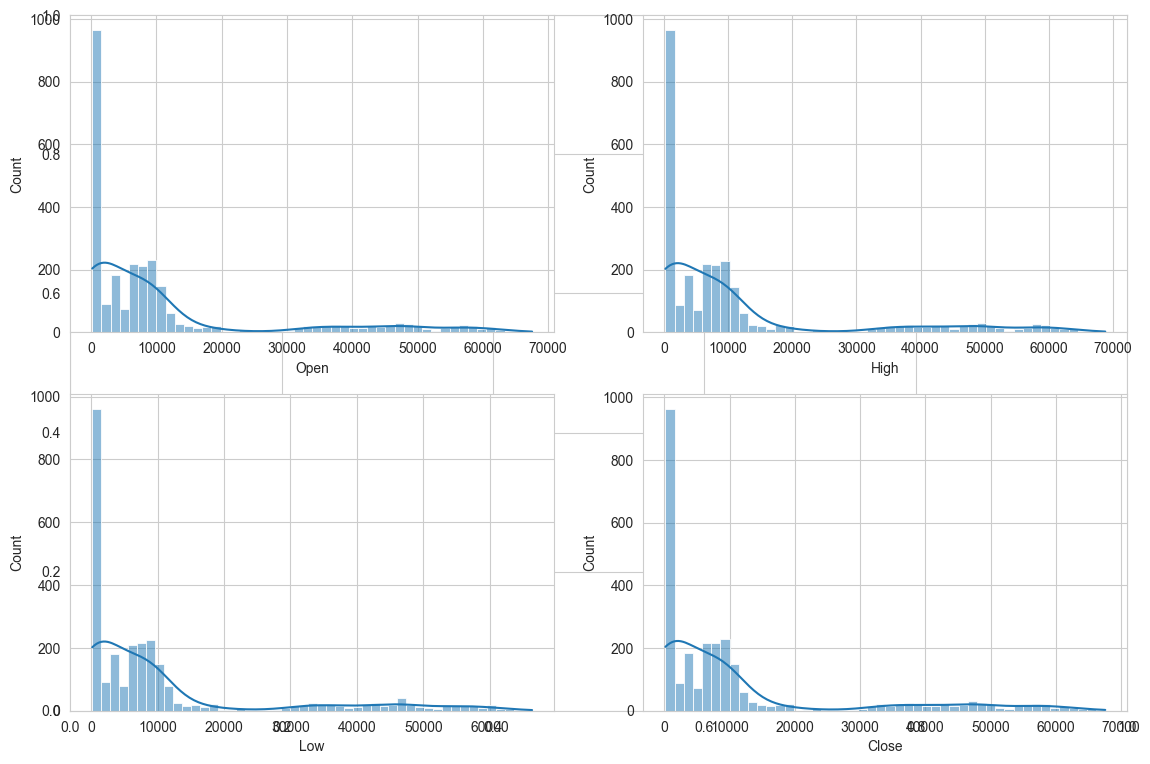

In [101]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(12,8))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.histplot(df[col], label=col, kde=True)
plt.tight_layout()
plt.show()

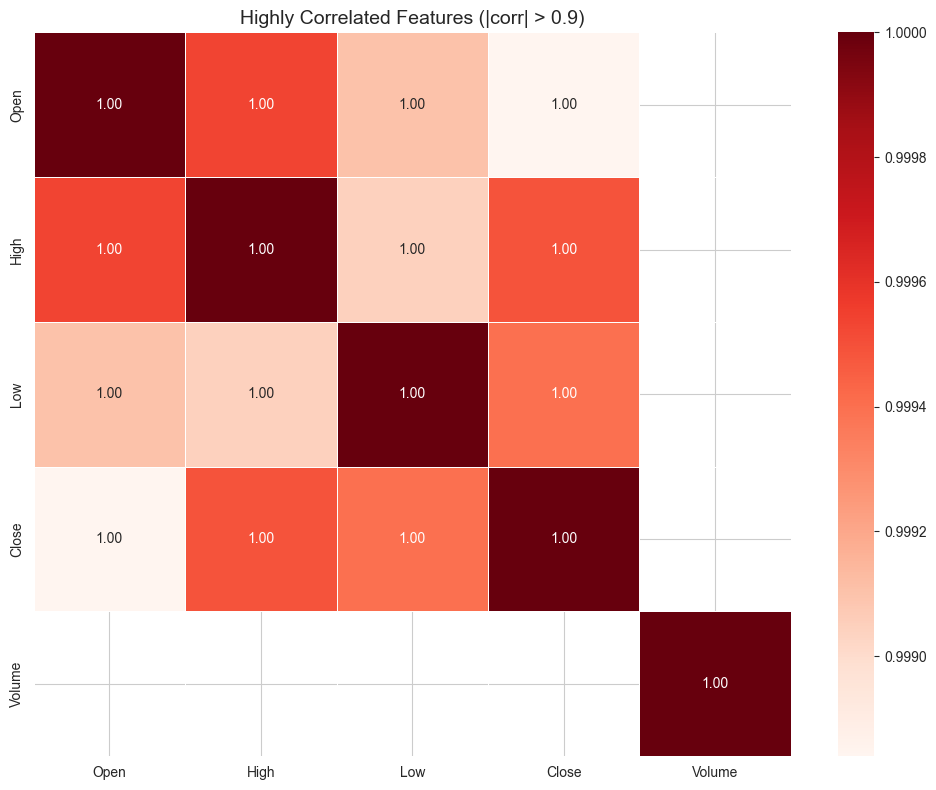

In [102]:
plt.figure(figsize=(10, 8))

corr = df.corr(numeric_only=True)
mask = corr <= 0.9

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
)

plt.title("Highly Correlated Features (|corr| > 0.9)", fontsize=14)
plt.tight_layout()
plt.show()

#### Feature Engineering

In [103]:
split = df['Date'].str.split('-', expand=True)

df['year'] = split[0].astype('int')
df['month'] = split[1].astype('int')
df['day'] = split[2].astype('int')

df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


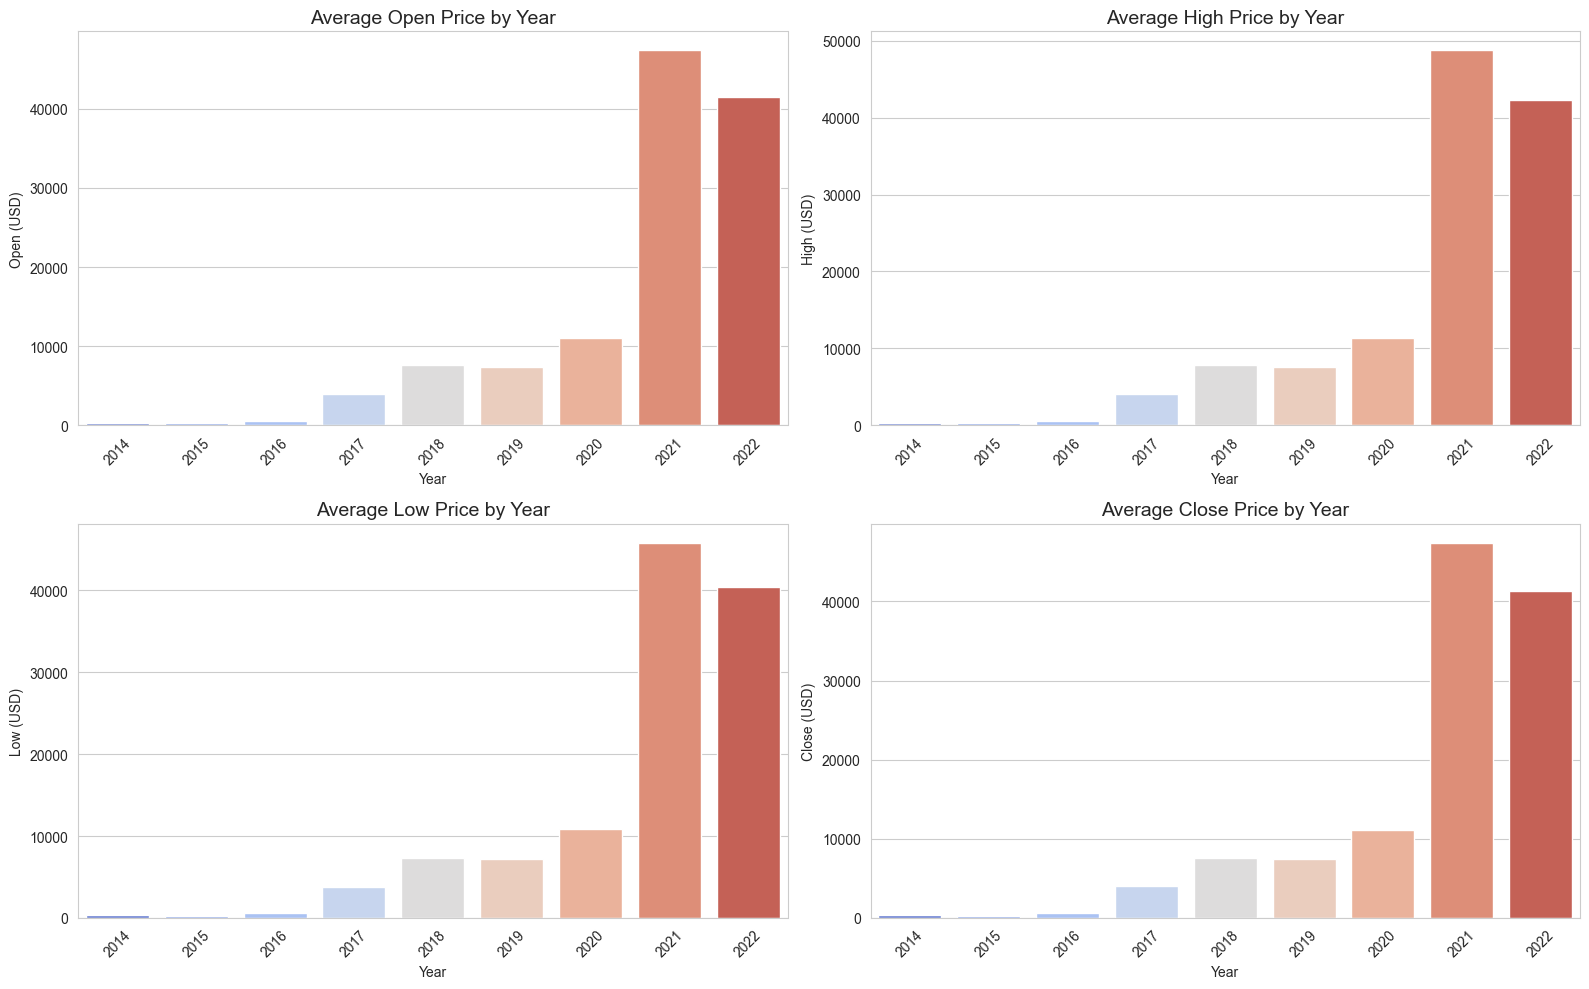

In [104]:
data_grouped = df.groupby('year')[['Open', 'High', 'Low', 'Close']].mean().reset_index()

sns.set_style('whitegrid')
plt.figure(figsize=(16, 10))

cols = ['Open', 'High', 'Low', 'Close']

for i, col in enumerate(cols):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x='year', y=col, data=data_grouped, palette='coolwarm')
    plt.title(f'Average {col} Price by Year', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel(f'{col} (USD)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [105]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,open-close,low-high,target
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,-15.752014,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,-43.755981,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,-43.302978,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,-33.412994,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,-19.244995,1


#### Modeling

In [106]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']
std = StandardScaler()
features = std.fit_transform(features)
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.3, random_state=42)

In [108]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (poly)": SVC(kernel='poly', probability=True),
    "RandomForest": RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='roc_auc')
    print(f"{name:<20} | AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Logistic Regression  | AUC: 0.5170 ± 0.0237
SVM (poly)           | AUC: 0.5265 ± 0.0204
RandomForest         | AUC: 0.4897 ± 0.0351
